In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys
from dictys.net import stat
import joblib

In [2]:
from utils_custom import *

In [3]:
# Define file paths 
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files'
data_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(data_folder, 'dynamic.h5'))

# Geneset regulatory activity

In [91]:
def read_gmt_file(gmt_path):
    """
    Read a GMT file and return a dictionary of gene sets.
    
    Parameters:
    -----------
    gmt_path : str
        Path to the GMT file
        
    Returns:
    --------
    dict : Dictionary with gene set names as keys and gene lists as values
    """
    gene_sets = {}
    with open(gmt_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            # First field is name, second is description (we'll skip it)
            name = parts[0]
            # Remaining fields are genes
            genes = [g.upper() for g in parts[2:]]  # Convert to uppercase
            gene_sets[name] = genes
    
    return gene_sets

In [96]:
# Load the GMT file
kegg_gmt_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/KEGG_CELL_CYCLE.v2024.1.Hs.gmt'
gobp_gmt_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/GOBP_CELL_CYCLE.v2024.1.Hs.gmt'
phase_gmt_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/CELL_CYCLE_PHASE.v2024.1.Hs.gmt'
# create a list of genes from the dicts
cell_cycle_kegg_genes = list(read_gmt_file(kegg_gmt_file)['KEGG_CELL_CYCLE'])
cell_cycle_gobp_genes = list(read_gmt_file(gobp_gmt_file)['GOBP_CELL_CYCLE'])
cell_cycle_phase_genes = list(read_gmt_file(phase_gmt_file)['CELL_CYCLE_PHASE'])
display(len(cell_cycle_kegg_genes))
display(len(cell_cycle_gobp_genes))
display(len(cell_cycle_phase_genes))


125

1684

170

In [ ]:
kegg_cell_cycle_in_object = check_if_gene_in_ndict(dictys_dynamic_object, cell_cycle_kegg_genes, return_index=True)
print(f"Found {len(kegg_cell_cycle_in_object['present'])} genes")
print(f"Missing {len(kegg_cell_cycle_in_object['missing'])} genes")
print("Indices:", kegg_cell_cycle_in_object['indices'])
# create a list of genes that are in the object from te indices dict keys
kegg_cell_cycle_genes = list(kegg_cell_cycle_in_object['indices'].keys())
display(len(kegg_cell_cycle_genes))
# get lcpm chars for these genes

In [5]:
# load LF files 
z11_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z11.txt'
z3_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z3.txt'

# load into a list of gene names 
z11 = pd.read_csv(z11_file, sep='\t', header=0)
z3 = pd.read_csv(z3_file, sep='\t', header=0)

# get the gene names 
z11_genes = z11['names'].tolist()
z3_genes = z3['names'].tolist()

# create a list of all lf genes 
lf_genes = list(set(z11_genes + z3_genes))


In [6]:
lf_in_object = check_if_gene_in_ndict(dictys_dynamic_object, lf_genes, return_index=True)
print(f"Found {len(lf_in_object['present'])} genes")
print(f"Missing {len(lf_in_object['missing'])} genes")
print("Indices:", lf_in_object['indices'])


Found 68 genes
Missing 0 genes
Indices: {'HLA-DRA': 4200, 'DEK': 2479, 'RUNX2': 8586, 'SUB1': 9706, 'PAX5': 6943, 'MZB1': 6199, 'PRDM1': 7604, 'IGHM': 4421, 'SLC25A13': 9042, 'FNDC3A': 3516, 'RNF213': 8355, 'HLA-DQA1': 4196, 'TRAM1': 10472, 'HLA-DPA1': 4194, 'CEP128': 1733, 'IQGAP2': 4638, 'MED23': 5675, 'TRAM2': 10473, 'AFF3': 230, 'FNDC3B': 3517, 'GAB1': 3613, 'CD99': 1598, 'CDK6': 1665, 'PIKFYVE': 7235, 'PIM2': 7239, 'HSP90B1': 4304, 'HLA-DMA': 4190, 'TXNDC5': 10727, 'ARNTL2': 665, 'HLA-C': 4189, 'EEA1': 2862, 'CD74': 1586, 'CD52': 1574, 'BTG2': 1106, 'UBAC2': 10759, 'CTSH': 2270, 'B2M': 872, 'IRF4': 4652, 'SSR1': 9582, 'MAN1A1': 5488, 'LMAN1': 5269, 'MAPK1': 5543, 'HLA-DMB': 4191, 'GLCCI1': 3767, 'TIAM1': 10070, 'CIITA': 1884, 'HM13': 4210, 'ELL2': 2979, 'PPIB': 7507, 'HLA-DQB1': 4198, 'HLA-B': 4188, 'SEL1L3': 8763, 'XBP1': 11200, 'JCHAIN': 4730, 'TXNDC11': 10722, 'HLA-A': 4187, 'HLA-DPB1': 4195, 'CPEB4': 2131, 'TNFAIP8': 10337, 'HLA-DRB1': 4201, 'CD79A': 1587, 'CCSER2': 1534, 'ANK

## Expression dynamics of the genes

In [7]:
# get lcpm chars for these genes
lcpm_dcurve_pb, dtime_pb = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=2, num=100, dist=0.0005, mode="expression")
# slice the dcurve for the lf genes using gene names which are indices in pandas df
lf_lcpm_dcurve_pb = lcpm_dcurve_pb.loc[lf_genes]
# get dchars for these genes
lf_lcpm_dchar_pb = compute_curve_characteristics(lf_lcpm_dcurve_pb, dtime_pb)
display(lf_lcpm_dchar_pb)

,Terminal logFC,Transient logFC,Switching time
HLA-DRA,-0.692791,0.000000,0.670680
DEK,-2.233877,0.000000,0.382910
RUNX2,2.649100,0.000000,0.472686
SUB1,1.406037,-0.094326,0.519105
PAX5,-2.462333,0.064915,0.569749
...,...,...,...
SLAMF7,0.986037,0.000000,0.653883
PDE4D,0.432650,0.351284,0.043978
TBC1D4,-2.286696,0.000005,0.484723
ARFGAP3,1.552766,-0.012234,0.583607


In [8]:
# get lcpm chars for these genes
lcpm_dcurve_gc, dtime_gc = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=3, num=100, dist=0.0005, mode="expression")
# slice the dcurve for the lf genes using gene names which are indices in pandas df
lf_lcpm_dcurve_gc = lcpm_dcurve_gc.loc[lf_genes]
# get dchars for these genes
lf_lcpm_dchar_gc = compute_curve_characteristics(lf_lcpm_dcurve_gc, dtime_gc)
display(lf_lcpm_dchar_gc)

,Terminal logFC,Transient logFC,Switching time
HLA-DRA,-0.295109,-0.006198,0.339376
DEK,0.483642,0.000000,0.522985
RUNX2,-1.146359,0.196928,0.690463
SUB1,-0.339612,0.017339,0.649028
PAX5,0.580667,-0.025721,0.660373
...,...,...,...
SLAMF7,-1.504904,0.003300,0.532318
PDE4D,-0.461597,-0.013830,0.398968
TBC1D4,1.364014,0.150674,0.281228
ARFGAP3,-0.386561,0.007096,0.503668


#### Choosing the genes which are dynamically divergent in lineages from the LFs

In [9]:
def find_dynamically_opposite_genes(gc_dchar: pd.DataFrame, pb_dchar: pd.DataFrame, min_effect: float = 0.1):
    """
    Find genes with opposite effects between GC and PB lineages by:
    1. Filtering out low effect genes
    2. Normalizing metrics within each condition separately
    3. Finding dominant effect (Terminal/Transient) for each gene in each condition
    4. Comparing signs of dominant effects
    
    Parameters:
    -----------
    gc_dchar, pb_dchar : pd.DataFrame
        DataFrames with 'Terminal logFC' and 'Transient logFC' columns
    min_effect : float
        Minimum absolute effect size threshold for filtering
    
    Returns:
    --------
    list : List of genes with opposite dominant effects between conditions
    """
    # Filter genes with low effect sizes in both conditions
    gc_filtered = gc_dchar[
        (abs(gc_dchar['Terminal logFC']) >= min_effect) | 
        (abs(gc_dchar['Transient logFC']) >= min_effect)
    ].copy()
    
    pb_filtered = pb_dchar[
        (abs(pb_dchar['Terminal logFC']) >= min_effect) | 
        (abs(pb_dchar['Transient logFC']) >= min_effect)
    ].copy()
    
    # Get common genes after filtering
    common_genes = list(set(gc_filtered.index) & set(pb_filtered.index))
    gc_filtered = gc_filtered.loc[common_genes]
    pb_filtered = pb_filtered.loc[common_genes]
    
    # Create normalized versions
    gc_norm = gc_filtered.copy()
    pb_norm = pb_filtered.copy()
    
    # Normalize GC metrics
    gc_terminal_abs = np.abs(gc_filtered['Terminal logFC'])
    gc_terminal_min = gc_terminal_abs.min()
    gc_terminal_max = gc_terminal_abs.max()
    gc_norm['Terminal logFC'] = (gc_terminal_abs - gc_terminal_min) / (gc_terminal_max - gc_terminal_min)
    gc_norm['Terminal logFC'] *= np.sign(gc_filtered['Terminal logFC'])
    
    gc_transient_abs = np.abs(gc_filtered['Transient logFC'])
    gc_transient_min = gc_transient_abs.min()
    gc_transient_max = gc_transient_abs.max()
    gc_norm['Transient logFC'] = (gc_transient_abs - gc_transient_min) / (gc_transient_max - gc_transient_min)
    gc_norm['Transient logFC'] *= np.sign(gc_filtered['Transient logFC'])
    
    # Normalize PB metrics
    pb_terminal_abs = np.abs(pb_filtered['Terminal logFC'])
    pb_terminal_min = pb_terminal_abs.min()
    pb_terminal_max = pb_terminal_abs.max()
    pb_norm['Terminal logFC'] = (pb_terminal_abs - pb_terminal_min) / (pb_terminal_max - pb_terminal_min)
    pb_norm['Terminal logFC'] *= np.sign(pb_filtered['Terminal logFC'])
    
    pb_transient_abs = np.abs(pb_filtered['Transient logFC'])
    pb_transient_min = pb_transient_abs.min()
    pb_transient_max = pb_transient_abs.max()
    pb_norm['Transient logFC'] = (pb_transient_abs - pb_transient_min) / (pb_transient_max - pb_transient_min)
    pb_norm['Transient logFC'] *= np.sign(pb_filtered['Transient logFC'])
    
    opposite_genes = []
    
    # Compare dominant effects for each gene
    for idx in common_genes:
        # Get normalized values
        gc_terminal = gc_norm.at[idx, 'Terminal logFC']
        gc_transient = gc_norm.at[idx, 'Transient logFC']
        pb_terminal = pb_norm.at[idx, 'Terminal logFC']
        pb_transient = pb_norm.at[idx, 'Transient logFC']
        
        # Determine dominant effect for each condition
        gc_dominant_val = gc_terminal if abs(gc_terminal) >= abs(gc_transient) else gc_transient
        pb_dominant_val = pb_terminal if abs(pb_terminal) >= abs(pb_transient) else pb_transient
        
        # Check if dominant effects have opposite signs
        if gc_dominant_val * pb_dominant_val < 0:
            opposite_genes.append(idx)
    return opposite_genes


In [10]:
opposite_genes = find_dynamically_opposite_genes(lf_lcpm_dchar_gc, lf_lcpm_dchar_pb, min_effect=0.3)
display(len(opposite_genes))

21

In [11]:
# order the opposite genes by keeping the upregulated genes first then downregulated genes
opposite_genes_ordered_pb = sorted(opposite_genes, key=lambda x: lf_lcpm_dchar_pb.at[x, 'Terminal logFC'], reverse=True)
opposite_genes_ordered_gc = sorted(opposite_genes, key=lambda x: lf_lcpm_dchar_gc.at[x, 'Terminal logFC'], reverse=True)


#### Genes with the most significant effect size changes per lineage

In [12]:
def get_top_terminal_effect_genes(dchar: pd.DataFrame, n_top: int = 15):
    """
    Get top genes based on their normalized effect sizes.
    
    Parameters:
    -----------
    dchar : pd.DataFrame
        DataFrame with 'Terminal logFC' and 'Transient logFC' columns
    n_top : int
        Number of top genes to return
    
    Returns:
    --------
    list : List of top genes sorted by combined normalized effect size
    """
    # Create normalized version of the dataframe
    norm_dchar = dchar.copy()
    
    # Normalize Terminal logFC
    terminal_abs = np.abs(dchar['Terminal logFC'])
    terminal_min = terminal_abs.min()
    terminal_max = terminal_abs.max()
    norm_dchar['Terminal logFC'] = (terminal_abs - terminal_min) / (terminal_max - terminal_min)
        
    # Sort by combined effect and get top genes
    top_genes = norm_dchar.nlargest(n_top, 'Terminal logFC').index.tolist()
    
    print(f"Top {n_top} genes by effect size:")
    for i, gene in enumerate(top_genes, 1):
        effect = norm_dchar.at[gene, 'Terminal logFC']
        print(f"{i}. {gene}: {effect:.3f}")
    
    return top_genes

In [13]:
# Usage:
top_pb_genes = get_top_terminal_effect_genes(lf_lcpm_dchar_pb, n_top=10)
top_gc_genes = get_top_terminal_effect_genes(lf_lcpm_dchar_gc, n_top=10)

Top 10 genes by effect size:
1. JCHAIN: 1.000
2. AFF3: 0.887
3. PRDM1: 0.859
4. FNDC3B: 0.822
5. TRAM2: 0.681
6. MZB1: 0.675
7. IGHM: 0.638
8. XBP1: 0.614
9. TXNDC5: 0.611
10. TXNDC11: 0.604
Top 10 genes by effect size:
1. JCHAIN: 1.000
2. MED23: 0.685
3. SLAMF7: 0.676
4. BTG2: 0.617
5. TBC1D4: 0.612
6. CD52: 0.609
7. PIM2: 0.576
8. ARNTL2: 0.544
9. RUNX2: 0.515
10. FNDC3B: 0.498


In [14]:
# take a union of top_genes and opposite_genes
dynamic_pb_genes = list(set(top_pb_genes + opposite_genes))
dynamic_gc_genes = list(set(top_gc_genes + opposite_genes))
display(len(dynamic_pb_genes))
display(len(dynamic_gc_genes))
# save the dynamic_pb_genes and dynamic_gc_genes
#np.save(os.path.join(output_folder, 'dynamic_pb_genes.npy'), dynamic_pb_genes)
#np.save(os.path.join(output_folder, 'dynamic_gc_genes.npy'), dynamic_gc_genes)


30

24

In [15]:
# order the dynamic_pb_genes by the switching time
dynamic_pb_genes_ordered = sorted(dynamic_pb_genes, key=lambda x: lf_lcpm_dchar_pb.at[x, 'Switching time'])
dynamic_gc_genes_ordered = sorted(dynamic_gc_genes, key=lambda x: lf_lcpm_dchar_gc.at[x, 'Switching time'])

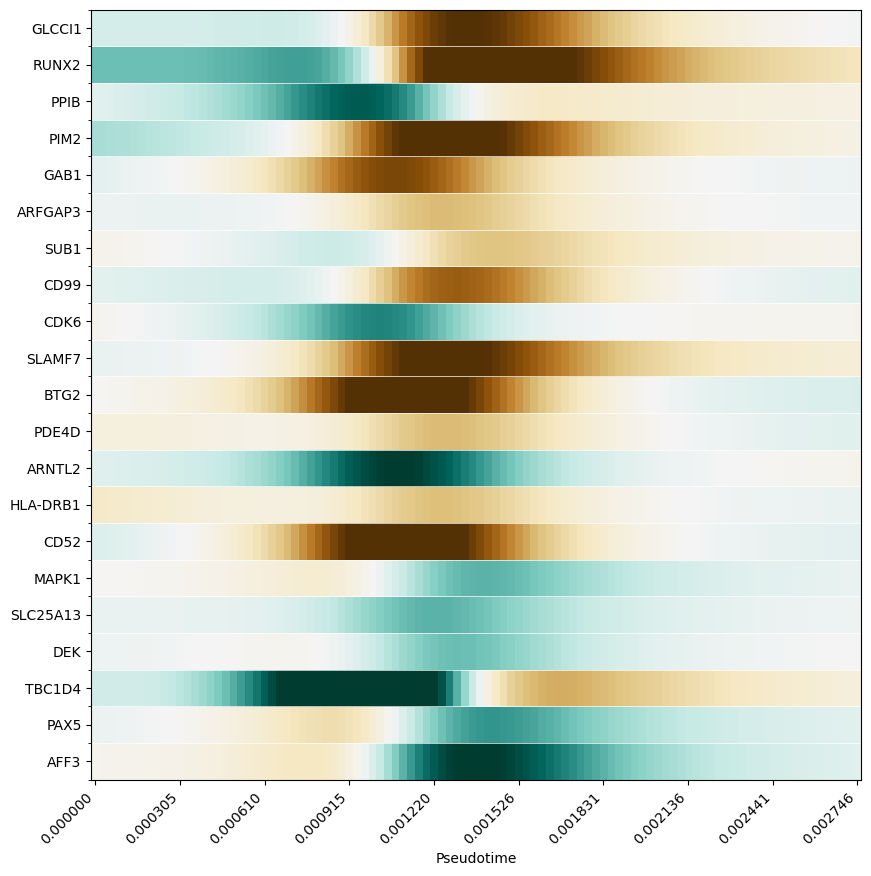

In [18]:
# Create figure for up-regulated genes
fig, ax = plt.subplots(figsize=(10, 10))
# Get genes from the up_regulated category
#transient_down_genes = lf_classifications['transient_down']
# Plot expression gradient for up-regulated genes
fig, ax, cmap = fig_expression_gradient_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=3,
    genes_or_regulations=opposite_genes_ordered_pb,
    num=100,
    dist=0.0005,
    ax=ax,
    cmap="BrBG",
    figsize=(10, 0.3)
)

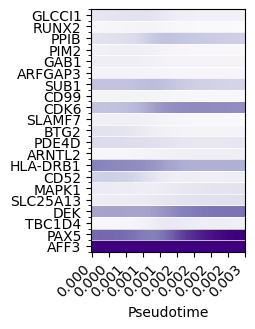

In [17]:
fig, ax, cmap = fig_expression_linear_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=3,
    genes_or_regulations=opposite_genes_ordered_pb,
    num=100,
    dist=0.0005,
    cmap='Purples'
)
plt.show()


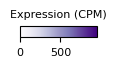

In [18]:
# Create matching colorbar
from dictys.plot import colorbar
fs = 8  # font size to match fig_discover style

ans2 = colorbar(
    cmap, 
    orientation='horizontal',
    figsize=(1, 0.15),
    title='Expression (CPM)',
    title_fontsize=fs
)
ans2[1].tick_params(axis='x', labelsize=fs)
plt.show()

# Regulations and beta characteristics

#### Get subnetworks for the dynamic genes in one lineage

In [16]:
pts, fsmooth = dictys_dynamic_object.linspace(0,2,100,0.0005)
stat1_net = fsmooth(stat.net(dictys_dynamic_object))
stat1_netbin = stat.fbinarize(stat1_net,sparsity=0.01)
stat1_x=stat.pseudotime(dictys_dynamic_object,pts)
dtime = pd.Series(stat1_x.compute(pts)[0])

In [17]:
# compute the binary network to get the indices of genes to keep based on sparsity
dnetbin = stat1_netbin.compute(pts)
display(dnetbin.shape)

(551, 11907, 100)

In [18]:
# compute the weighted network
dnet = stat1_net.compute(pts)
display(dnet.shape)

(551, 11907, 100)

In [20]:
# save the dnet and dnetbin
np.save(os.path.join(output_folder, 'dnet_pb.npy'), dnet)
np.save(os.path.join(output_folder, 'dnetbin_pb.npy'), dnetbin)


In [21]:
# get indices of the dynamic_pb_genes
dynamic_pb_genes_indices = get_gene_indices(dictys_dynamic_object, dynamic_pb_genes)
display(len(dynamic_pb_genes_indices))  

30

In [22]:
subnetworks_bin = dnetbin[np.ix_(range(dnetbin.shape[0]), dynamic_pb_genes_indices, range(dnetbin.shape[2]))]
display(subnetworks_bin.shape)

(551, 30, 100)

#### Filter TFs from the entire list (551)

In [23]:
# Calculate sparsity for each TF (across all genes and timepoints)
TF_density = (subnetworks_bin != 0).mean(axis=(1, 2))
# Keep TFs that are non-zero more than x% of the time
TFs_to_keep = TF_density > 0.01
TFs_to_keep_indices = np.where(TFs_to_keep)[0]

# Get TF names
# Create reverse mapping: index -> gene_name
ndict = dictys_dynamic_object.ndict
index_to_gene = {idx: name for name, idx in ndict.items()}
# Get TF_gene_indices from TFs_to_keep_indices using nids[0]
TFs_to_keep_gene_indices = [dictys_dynamic_object.nids[0][tf_idx] for tf_idx in TFs_to_keep_indices]
kept_tf_names = [index_to_gene[idx] for idx in TFs_to_keep_gene_indices]
print(len(kept_tf_names))

220


In [24]:
# Get the subnetworks for the kept TFs
filtered_subnetworks = dnet[np.ix_(TFs_to_keep_indices, dynamic_pb_genes_indices, range(dnet.shape[2]))]
display(filtered_subnetworks.shape)

(220, 30, 100)

#### Get beta dchars for a lineage


In [25]:
# Create multi-index tuples (all combinations of TF-target pairs)
index_tuples = [(tf, target) for tf in kept_tf_names for target in dynamic_pb_genes]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = filtered_subnetworks.shape
reshaped_data = filtered_subnetworks.reshape(-1, n_times)

# Create DataFrame with multi-index
lf_beta_dcurve_pb = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)
display(lf_beta_dcurve_pb.head())

time_0    time_1    time_2    time_3    time_4    time_5  \
TF  Target                                                               
AHR DEK     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    RUNX2   0.031499  0.032104  0.032718  0.033330  0.033929  0.034507   
    SUB1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    MZB1    0.009809  0.009792  0.009707  0.009559  0.009352  0.009093   
    PAX5    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

              time_6    time_7    time_8    time_9  ...       time_90  \
TF  Target                                          ...                 
AHR DEK     0.000000  0.000000  0.000000  0.000000  ...  0.000000e+00   
    RUNX2   0.035053  0.035557  0.036012  0.036411  ... -1.550720e-01   
    SUB1    0.000000  0.000000  0.000000  0.000000  ...  0.000000e+00   
    MZB1    0.008787  0.008442  0.008065  0.007662  ...  2.814139e-13   
    PAX5    0.000000  0.000000  0.000000  0.000000  ...  0.000000e+00   

                 time_91       time_92       time_93       time_94  \
TF  Target                                                           
AHR DEK     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    RUNX2  -1.626678e-01 -1.702431e-01 -1.777739e-01 -1.852370e-01   
    SUB1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    MZB1    1.658864e-13  9.752802e-14  5.719150e-14  3.345388e-14   
    PAX5    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                 time_95       time_96       time_97       time_98  \
TF  Target                                                           
AHR DEK     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    RUNX2  -1.926094e-01 -1.998694e-01 -2.069960e-01 -2.139695e-01   
    SUB1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    MZB1    1.952104e-14  1.136393e-14  6.600109e-15  3.824694e-15   
    PAX5    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                 time_99  
TF  Target                
AHR DEK     0.000000e+00  
    RUNX2  -2.207715e-01  
    SUB1    0.000000e+00  
    MZB1    2.211523e-15  
    PAX5    0.000000e+00  

[5 rows x 100 columns]

In [26]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
import math
from tqdm import tqdm

def process_chunk(args):
    """Process a chunk of curves to compute characteristics"""
    chunk_df, dtime = args
    results = {}
    for idx in chunk_df.index:
        curve = chunk_df.loc[idx]
        char_dict = compute_curve_characteristics(pd.DataFrame(curve).T, dtime)
        results[idx] = char_dict.iloc[0]
    return pd.DataFrame.from_dict(results, orient='index')

# Split data into chunks
n_cores = 8  # Adjust based on your CPU
chunk_size = math.ceil(len(lf_beta_dcurve_pb) / n_cores)
chunks = []

for i in range(0, len(lf_beta_dcurve_pb), chunk_size):
    chunk = lf_beta_dcurve_pb.iloc[i:i + chunk_size]
    chunks.append((chunk, dtime))

# Process chunks in parallel with progress bar
with Pool(n_cores) as pool:
    results = list(tqdm(
        pool.imap(process_chunk, chunks),
        total=len(chunks),
        desc="Processing curves"
    ))

# Combine results and sort
lf_beta_dchar_pb = pd.concat(results).sort_index()
#beta_chars_pb_sliced.to_csv(os.path.join(output_folder, 'betas_chars_pb_220_30.csv'))


Processing curves: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


#### Scale normalize the terminal and transient beta dchar


In [27]:
def normalize_and_rank_regulations(df):
    """
    Normalize regulations to [-1, 1] scale and rank by absolute effect size.
    """
    # Create copy
    df_norm = df.copy()
    
    # Normalize Terminal logFC to [-1, 1]
    terminal_max = max(abs(df['Terminal logFC'].min()), abs(df['Terminal logFC'].max()))
    df_norm['norm_Terminal'] = df['Terminal logFC'] / terminal_max if terminal_max != 0 else 0
    
    # Normalize Transient logFC to [-1, 1]
    transient_max = max(abs(df['Transient logFC'].min()), abs(df['Transient logFC'].max()))
    df_norm['norm_Transient'] = df['Transient logFC'] / transient_max if transient_max != 0 else 0
    
    # Get maximum absolute effect (for ranking)
    df_norm['max_abs_effect'] = df_norm[['norm_Terminal', 'norm_Transient']].abs().max(axis=1)
    
    # Rank based on absolute effect size
    df_norm['regulation_rank'] = df_norm['max_abs_effect'].rank(ascending=False)
    
    # Sort by rank
    df_norm = df_norm.sort_values('regulation_rank')
    return df_norm

def get_top_regulations(df, n_top=10, effect_type='positive'):
    """
    Get top positive, negative, or all/both regulations based on normalized effect size.
    """
    if effect_type == 'positive':
        mask = (df['norm_Terminal'] > 0) | (df['norm_Transient'] > 0)
    elif effect_type == 'negative':
        mask = (df['norm_Terminal'] < 0) | (df['norm_Transient'] < 0)
    else:
        mask = slice(None)
        
    filtered_df = df[mask] if effect_type != 'all' else df
    top_regs = filtered_df.nlargest(n_top, 'max_abs_effect')
    return top_regs

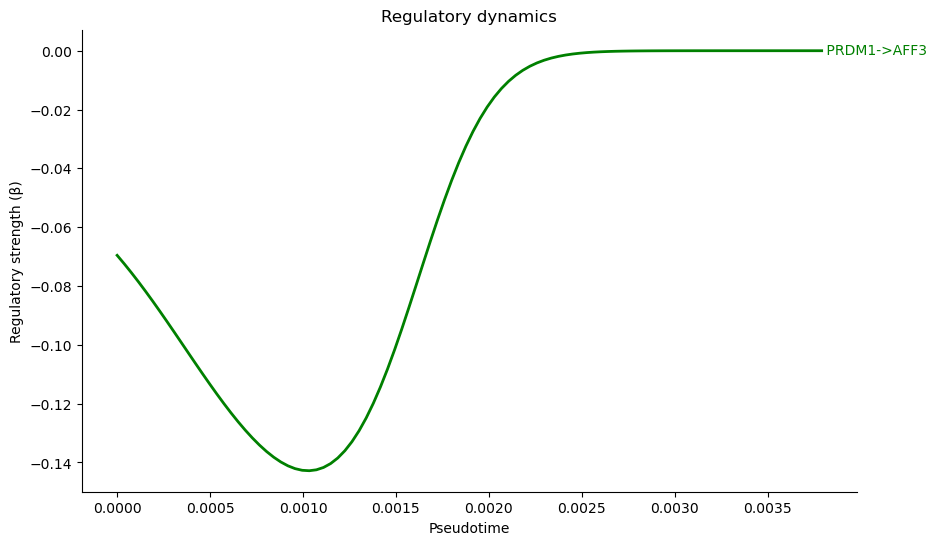

In [ ]:
# Plot beta trajectories
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Specify TF-target pairs of interest
regulations_of_interest = [('PRDM1', 'AFF3')]
colors = ['green']   # Define colors for each regulation

for (tf, target), color in zip(regulations_of_interest, colors):
    # Create multi-index key for the regulation
    idx = pd.MultiIndex.from_tuples([(tf, target)])
    if (tf, target) in lf_beta_dcurve_pb.index:
        line = plt.plot(dtime, lf_beta_dcurve_pb.loc[(tf, target)], 
                       linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(dtime.iloc[-1], 
                lf_beta_dcurve_pb.loc[(tf, target)].iloc[-1], 
                f' {tf}->{target}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('Regulatory strength (β)')
plt.title('Regulatory dynamics')
plt.show()

## Getting the top regulations for a geneset
### 1. Per-gene get the max force at each time-point to get the regulations that explain the gene's expression dynamics best. Directionality does not matter in this selection of the maximum force.

In [28]:
# get the tf_lcpms for the lineage
kept_tfs_lcpm_dcurve_pb = lcpm_dcurve_pb.loc[kept_tf_names]

In [36]:
def calculate_force_curves(beta_curves: pd.DataFrame, tf_expression: pd.Series) -> pd.DataFrame:
    """
    Calculate force curves using log transformation
    """
    # Count number of targets per TF from beta_curves multi-index
    targets_per_tf = beta_curves.index.get_level_values(0).value_counts()
    # Create a DataFrame with repeated TF expression values for each target
    expanded_tf_expr = pd.DataFrame(
        np.repeat(tf_expression.values, targets_per_tf.values, axis=0),  # Repeat each TF's row 30 times
        index=beta_curves.index,  # Use beta_curves' multi-index
        columns=beta_curves.columns
    )
    # Convert to numpy arrays for calculations
    beta_array = beta_curves.to_numpy()
    tf_array = expanded_tf_expr.to_numpy()
    # Add small epsilon to avoid log(0)
    epsilon = 1e-10
    log_beta = np.log10(np.abs(beta_array) + epsilon)
    log_tf = np.log10(tf_array + epsilon)
    # Preserve signs from original beta values
    signs = np.sign(beta_array)
    # Calculate forces 
    force_array = signs * np.exp(log_beta + log_tf)
    # Convert back to DataFrame with original index/columns
    force_curves = pd.DataFrame(
        force_array, 
        index=beta_curves.index, 
        columns=beta_curves.columns
    )
    return force_curves

In [37]:
lf_forces_dcurve_pb = calculate_force_curves(lf_beta_dcurve_pb, kept_tfs_lcpm_dcurve_pb)
display(lf_forces_dcurve_pb.head())
display(lf_forces_dcurve_pb.shape)

time_0    time_1    time_2    time_3    time_4    time_5  \
TF  Target                                                               
AHR DEK     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    RUNX2   0.524952  0.529545  0.534066  0.538444  0.542608  0.546495   
    SUB1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    MZB1    0.316279  0.316180  0.315079  0.313020  0.310051  0.306228   
    PAX5    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

              time_6    time_7    time_8    time_9  ...   time_90   time_91  \
TF  Target                                          ...                       
AHR DEK     0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
    RUNX2   0.550048  0.553218  0.555963  0.558251  ... -0.928295 -0.946448   
    SUB1    0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
    MZB1    0.301614  0.296274  0.290278  0.283699  ...  0.000095  0.000095   
    PAX5    0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   

             time_92   time_93   time_94   time_95   time_96   time_97  \
TF  Target                                                               
AHR DEK     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    RUNX2  -0.964028 -0.981020 -0.997413 -1.013196 -1.028360 -1.042901   
    SUB1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    MZB1    0.000094  0.000094  0.000094  0.000094  0.000094  0.000094   
    PAX5    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

             time_98   time_99  
TF  Target                      
AHR DEK     0.000000  0.000000  
    RUNX2  -1.056812 -1.070093  
    SUB1    0.000000  0.000000  
    MZB1    0.000094  0.000094  
    PAX5    0.000000  0.000000  

[5 rows x 100 columns]

(6600, 100)

In [43]:
lf_force_curves_sorted_by_target = lf_forces_dcurve_pb.sort_index(level=1)
display(lf_force_curves_sorted_by_target.head())
display(lf_force_curves_sorted_by_target.shape)

,,time_0,time_1,time_2,time_3,time_4,time_5,time_6,time_7,time_8,time_9,...,time_90,time_91,time_92,time_93,time_94,time_95,time_96,time_97,time_98,time_99
TF,Target,,,,,,,,,,,,,,,,,,,,,
AHR,AFF3,0.223445,0.228261,0.232608,0.236461,0.239799,0.242607,0.244876,0.246604,0.247791,0.248447,...,0.681209,0.676838,0.673077,0.669959,0.667509,0.665741,0.664662,0.66427,0.664556,0.665503
ARID3B,AFF3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
ARID5A,AFF3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
ARNT,AFF3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
ARNTL,AFF3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


(6600, 100)

In [ ]:
def find_max_force_tfs(force_df):
    """
    Find TFs exerting maximum absolute force per target at each timepoint
    Returns DataFrame with force trajectories ordered by time of maximum force
    """
    # Initialize dictionary to store results
    max_force_dict = {}
    
    # Get unique targets
    targets = force_df.index.get_level_values(1).unique()
    
    # Process each target
    for target in targets:
        # Get all TFs for this target using boolean indexing
        target_mask = force_df.index.get_level_values(1) == target
        target_data = force_df[target_mask]
        
        # Store the max force TF indices for each timepoint
        max_force_indices = []
        for col in force_df.columns:
            # Find TF with max absolute force at this time point
            max_force_idx = target_data[col].abs().idxmax()
            max_force_indices.append(max_force_idx)
        
        # Get the force trajectories for these TFs
        max_force_trajectories = force_df.loc[max_force_indices]
        max_force_dict[target] = max_force_trajectories
    
    # Concatenate all target results
    result_df = pd.concat(max_force_dict.values())
    
    return result_df

# Use the function
max_force_trajectories = find_max_force_tfs(lf_force_curves_sorted_by_target)


Unique TFs that exerted maximum force on AFF3:
Index(['NRF1', 'RUNX3', 'SPIB', 'IKZF1', 'REL', 'CTCF'], dtype='object', name='TF')

Total number of unique TFs: 6


In [54]:
# Get all rows for target
target_mask = max_force_trajectories.index.get_level_values(1) == 'AFF3'
target_max_forces = max_force_trajectories[target_mask]

# Get unique TFs (from first level of multi-index)
unique_tfs = target_max_forces.index.get_level_values(0).unique()

print("Unique TFs that exerted maximum force on AFF3:")
print(unique_tfs)
print(f"\nTotal number of unique TFs: {len(unique_tfs)}")

Unique TFs that exerted maximum force on RUNX2:
Index(['NRF1', 'KLF6', 'PLAG1', 'HMBOX1', 'POU2F2'], dtype='object', name='TF')

Total number of unique TFs: 5
